# 数据挖掘电商产品类别预测

业务背景为某电商内部上品分类体系融合时，需要对商品进行重新分类。

- 评价指标为准确率Accuracy 
- 训练集train.csv中包含匿名特征及标签target
- 测试集test.csv仅包含匿名特征
- 项目任务
  1. 数据分析可视化，数据处理；
  2. 采用lightGBM完成建模；
  3. 采用Optuna库对lightGBM模型进行参数优化；
  4. 采用PyTorch完成深度学习建模；
  5. 融合机器学习 & 深度学习模型预测结果；

In [2]:
import pandas as pd
import numpy as np
import sklearn 
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans


In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

----
#  Visualization

<AxesSubplot:>

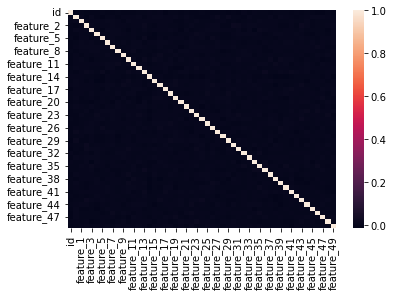

In [4]:
sns.heatmap(train.corr())

In [5]:
train

,id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,target
0,81819,0,0,0,0,0,0,0,3,0,...,0,0,0,0,1,0,0,0,0,Class_1
1,52877,1,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,2,1,0,Class_3
2,76874,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,5,2,2,Class_2
3,23007,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,Class_2
4,31906,0,0,0,11,0,0,0,5,0,...,1,0,0,0,0,0,0,2,0,Class_2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79995,96783,0,0,0,4,0,0,2,0,20,...,0,0,0,0,0,0,0,0,0,Class_4
79996,51898,0,0,0,0,0,0,0,0,0,...,2,0,0,0,0,0,1,1,0,Class_2
79997,1492,0,0,0,0,0,0,0,0,0,...,0,3,0,0,0,0,0,2,0,Class_4
79998,90984,5,0,0,0,0,0,11,2,2,...,0,0,0,0,0,0,0,0,0,Class_2


In [6]:
target = train['target']
train.drop(['target','id'], axis=1, inplace=True)
test.drop(['id'], axis=1, inplace=True)
train.describe()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49
count,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.00000,80000.000000,80000.000000,80000.000000,80000.000000,...,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000
mean,0.255738,0.433625,0.113787,0.593300,0.598075,0.16025,0.729513,1.232650,0.911013,0.936600,...,0.712087,0.581500,0.525188,0.615012,0.136300,0.357588,0.516088,0.394263,0.972800,0.558187
std,0.922590,1.995876,0.519609,1.856378,2.781237,0.59904,2.334581,2.704171,3.437385,1.898006,...,1.718475,1.995566,2.291033,2.357449,0.631983,1.465016,2.163383,1.504526,2.571059,1.684510
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,-2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,1.000000,0.000000,1.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,10.000000,31.000000,6.000000,26.000000,38.000000,10.00000,27.000000,30.000000,39.000000,17.000000,...,21.000000,32.000000,37.000000,33.000000,9.000000,26.000000,28.000000,25.000000,43.000000,20.000000


In [7]:
# total_sse=[]
# for i in range(1,51):
#     km = KMeans(n_clusters=i,verbose=-1,
#                 random_state=42,n_jobs=-1)
#     total_sse.append(km.fit(train).inertia_)
# plt.plot(range(1,51),total_sse)
# plt.xticks(range(1,51))

In [8]:
test.describe()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49
count,20000.00000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,...,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,0.26620,0.424100,0.115500,0.579550,0.606550,0.163100,0.739400,1.214000,0.872700,0.954200,...,0.713000,0.584350,0.545400,0.621500,0.130300,0.362950,0.519700,0.373150,0.963050,0.552850
std,0.95435,1.904132,0.519493,1.796506,2.802702,0.609522,2.378712,2.646498,3.325184,1.928623,...,1.735391,2.033074,2.339575,2.374978,0.609705,1.460898,2.203305,1.416478,2.598773,1.666567
min,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,10.00000,28.000000,6.000000,26.000000,34.000000,8.000000,26.000000,31.000000,32.000000,16.000000,...,20.000000,28.000000,34.000000,31.000000,9.000000,26.000000,29.000000,25.000000,44.000000,18.000000


In [9]:
train.isnull().sum().sum(),test.isnull().sum().sum()

(0, 0)

In [10]:
target.describe()

count       80000
unique          4
top       Class_2
freq        45962
Name: target, dtype: object

<AxesSubplot:xlabel='target', ylabel='Count'>

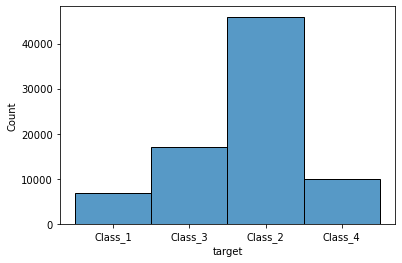

In [11]:
sns.histplot(target)

In [12]:
df = pd.concat([train,test], axis=0)
df.describe()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,...,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000,100000.00000
mean,0.257830,0.431720,0.114130,0.590550,0.599770,0.160820,0.731490,1.228920,0.903350,0.940120,...,0.712270,0.582070,0.529230,0.616310,0.135100,0.358660,0.516810,0.39004,0.970850,0.55712
std,0.929033,1.977862,0.519584,1.844558,2.785531,0.601149,2.343465,2.692732,3.415258,1.904172,...,1.721863,2.003114,2.300826,2.360955,0.627592,1.464187,2.171415,1.48735,2.576615,1.68093
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,-2.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000,0.00000
max,10.000000,31.000000,6.000000,26.000000,38.000000,10.000000,27.000000,31.000000,39.000000,17.000000,...,21.000000,32.000000,37.000000,33.000000,9.000000,26.000000,29.000000,25.00000,44.000000,20.00000


In [13]:
# val_sum = np.array(df).sum(1)
# df['sum'] = val_sum

In [14]:
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
# train = np.array(scaler.fit_transform(train))
# test = np.array(scaler.transform(test))

In [15]:
target = np.array(target.map({"Class_1":0, "Class_2":1, "Class_3":2, "Class_4":3}))

----
# GBM Modeling

## Params Optinization

In [16]:
def objective(trial):
    k_fold=3
    accuracy_sum = 0
    for i in range(k_fold):
        train_x, valid_x, train_y, valid_y = train_test_split(train, target, test_size=0.35)
        lgb_train_targets = lgb.Dataset(train_x, label=train_y)
        param = {

            "objective": "multiclass",
            "metric": "multi_error",
            "verbosity": -1,
            "boosting_type": "gbdt",
            "num_class":4, 
            # 'colsample_bytree': trial.suggest_float("colsample_bytree", 0.5, 0.9),
            # 'subsample': trial.suggest_float("subsample", 0.6, 0.8),
            'learning_rate': trial.suggest_float("learning_rate", 0.05, 0.2),
            'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
            'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
            "num_leaves": trial.suggest_int("num_leaves", 2, 256),
            "n_estimators": trial.suggest_int("n_estimators", 16, 1024),
            "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
            "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
            "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
            "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
            'seed': 42
        }
        
        gbm = lgb.train(param, lgb_train_targets)
        preds = gbm.predict(valid_x)
        preds = np.array([np.argwhere(x == x.max())for x in preds]).squeeze()
        accuracy_sum += sklearn.metrics.accuracy_score(valid_y, preds)
    accuracy = accuracy_sum/k_fold
    return accuracy

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

In [ ]:
print("Besttrial:")
trial=study.best_trial
print("Value:",trial.value)
print("Params:")
for key, value in trial.params.items():
    print("{}:{}".format(key,value))

Besttrial:
Value: 0.5767857142857143
Params:
learning_rate:0.013031298252275447
lambda_l1:9.467436548086597e-08
lambda_l2:0.27085918847321766
num_leaves:223
n_estimators:595
feature_fraction:0.4124325977011139
bagging_fraction:0.7005601297310573
bagging_freq:2
min_child_samples:71


In [ ]:
# def gbmpredict(train=train, target=target):
#     train_x, valid_x, train_y, valid_y = train_test_split(train, target, test_size=0.1)
#     lgb_train_targets = lgb.Dataset(train_x, label=train_y)
#     param = {
#         "objective": "multiclass",
#         "metric": "multi_error",
#         "verbosity": -1,
#         "boosting_type": "gbdt",
#         "num_class":4, 
#                 # 'colsample_bytree': trial.suggest_float("colsample_bytree", 0.5, 0.9),
#                 # 'subsample': trial.suggest_float("subsample", 0.6, 0.8),
#         'learning_rate': 0.05969785593242574,
#         'lambda_l1': 9.57481277431383,
#         'lambda_l2': 0.005569190507851442,
#         'feature_fraction': 0.441560863743879,
#         'bagging_fraction': 0.5669317908216961, 
#             'bagging_freq': 2,
#             'min_child_samples': 7,
#         'learning_rate': 0.05, 
#         'num_leaves': 39, 
#         "n_estimators":4096,
#     }

#     # k = 5
#     # gbm = lgb.train(param, lgb_train_targets)
#     # preds = gbm.predict(valid_x)
#     # preds = np.array([np.argwhere(x == x.max())for x in preds]).squeeze()
#     # accuracy_sum += sklearn.metrics.accuracy_score(valid_y, preds)
#     # accuracy = accuracy_sum/k_fold
#     # return accuracy      
#     gbm = lgb.train(param, lgb_train_targets)
#     lgb.plot_importance(gbm)
#     plt.figure(figsize=(8,20),dpi = 100)
#     plt.show()
#     preds = gbm.predict(train)
#     return preds

## Validation & Train & Predict

In [18]:
def gbmpredict(train=train, target=target, test=test):
    k_fold=5
    accuracy_sum = 0
    preds_on_test = 0
    preds_on_train = 0
    for i in range(k_fold):
        train_x, valid_x, train_y, valid_y = train_test_split(train, target, test_size=0.2)
        lgb_train_targets = lgb.Dataset(train_x, label=train_y)
        param = {
            "objective": "multiclass",
            "metric": "multi_error",
            "verbosity": -1,
            "boosting_type": "gbdt",
            "num_class":4, 
                    # 'colsample_bytree': trial.suggest_float("colsample_bytree", 0.5, 0.9),
                    # 'subsample': trial.suggest_float("subsample", 0.6, 0.8),
            'lambda_l1': 1.262252332496178,
            'lambda_l2': 0.29444165244400033,
            'feature_fraction': 0.7171898178218491,
            'bagging_fraction': 0.8102191911790236,
            'bagging_freq': 5,
            'min_child_samples': 28,
            'learning_rate': 0.05, 
            'num_leaves': 39, 
            "n_estimators":4096,

        }
        # gbm = lgb.train(param, lgb_train_targets)
        # preds = gbm.predict(valid_x)
        # preds = np.array([np.argwhere(x == x.max())for x in preds]).squeeze()
        # print(sklearn.metrics.accuracy_score(valid_y, preds))
        
        gbm = lgb.train(param, lgb_train_targets)
        preds = gbm.predict(valid_x)
        preds = np.array([np.argwhere(x == x.max())for x in preds]).squeeze()
        print(sklearn.metrics.accuracy_score(valid_y, preds))
        
        preds_on_test += gbm.predict(test)/k_fold
        preds_on_train += gbm.predict(train)/k_fold
        
    return preds_on_train,preds_on_test

In [19]:
preds_on_train,preds_on_test = gbmpredict()

0.5555625


D:\programs\envs\python38\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


0.5561875


D:\programs\envs\python38\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


0.561625


D:\programs\envs\python38\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


0.5539375


D:\programs\envs\python38\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


0.556625


In [20]:
preds_on_train = np.array(preds_on_train)
preds_on_test = np.array(preds_on_test)
preds_on_test.shape

(20000, 4)

In [21]:
gbm_ba = pd.DataFrame(preds_on_test)
gbm_ba.to_csv('gbm_ba.csv', index=False)

In [31]:

preds_on_train = np.array([np.argwhere(x == x.max())for x in preds_on_train]).squeeze()


array([1, 2, 1, ..., 1, 1, 1], dtype=int64)

<AxesSubplot:ylabel='Count'>

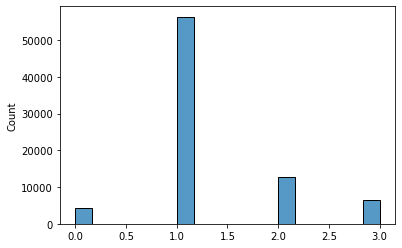

In [33]:

sns.histplot(preds_on_train)

In [34]:
sklearn.metrics.accuracy_score(target, preds_on_train)

0.8390625

----
# Torch Modeling

In [3]:
import torch
from torch.utils.data import Dataset,DataLoader
NUM_WORKERS = 0
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

## Features & Loss Weights

In [4]:
def add_features(df):
    df.drop(['id'], axis=1, inplace=True)
    # for i,col in enumerate(df.columns):
    #     df[col+str(2)] = df[col]*df[col]
    #     df[col+str(3)] = df[col+str(2)]*df[col]
        # df[col+'log'] = np.log(df[col])
        # df[col+'log'].loc[df[col+'log']==np.inf]=0
        # df[col+'log'].loc[df[col+'log']==-np.inf]=0
    # km = KMeans(n_clusters=24,random_state=42)
    # cluster = km.fit_predict(df)
    # df['Cluster'] = cluster 
    df.fillna(0)
    

In [5]:
def calc_weight(train):
    col_name = train.columns[3]
    class_cnt = np.array(train.groupby('target').agg('count')[col_name])
    
    entropy_weight = torch.Tensor(np.exp(np.sum(np.log2(class_cnt))/np.log2(class_cnt)))
    entropy_weight = entropy_weight.cuda()
    return entropy_weight

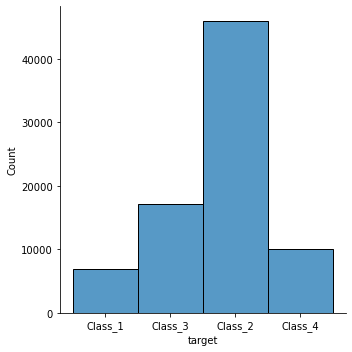

In [6]:
sns.displot(train.target)

In [7]:
from sklearn.preprocessing import StandardScaler
def prepare_data(train, test):
    target = train['target']
    target = np.array(target.map({"Class_1":0, "Class_2":1, "Class_3":2, "Class_4":3}))
    train.drop('target', axis=1, inplace=True)
    
    add_features(train)
    add_features(test)
    scaler = StandardScaler()
    train = pd.DataFrame(np.array(scaler.fit_transform(train)))
    test = pd.DataFrame(np.array(scaler.transform(test)))
    
    train['target'] = target
    
    entropy_weight = calc_weight(train)
    
    return train, test, test.shape[1], entropy_weight
train,test,INPUT_DIM,ENTROPY_WEIGHT = prepare_data(train, test)

In [8]:
debug = False
if debug:
    train = train[:8000]
else:
    train = train

In [9]:


class BusinessData(Dataset):

    def __init__(self, df):
        if "target" not in df.columns:
            df['target'] = 0
        self.df = df
        self.x_data = torch.Tensor(np.array(df.drop('target', axis=1)))
        self.y_data = torch.Tensor(np.array(df.target))
        self.len = df.shape[0]

    def __getitem__(self, index):
        data = {
            "x_data":  torch.tensor(self.x_data[index],dtype=torch.float),
            "y_data": torch.tensor(self.y_data[index],dtype=torch.float)
        }
        return data 

    def __len__(self):
        return self.len

# business_data = BusinessData()

# train_loader = DataLoader(dataset=business_data,
#                         batch_size=128,
#                         shuffle=True)

## Model

In [10]:
import torch.nn as nn


class MlpModel(nn.Module):
    def __init__(
        self,
        input_dim=50,
        dense_dim=256,
        sep_dim1=256,
        sep_dim2=256,        
        comb_dim1=256,
        comb_dim2=256,
        last_dim=256,
        num_classes=4
        ):
        super().__init__()

        self.mlp1 = nn.Sequential(
            nn.Linear(input_dim, dense_dim),
            nn.SELU(),
            nn.Linear(dense_dim, sep_dim1),
            nn.SELU(),
        )
        self.mlp2 = nn.Sequential(
            nn.Linear(sep_dim1, dense_dim //2),
            nn.SELU(),
            nn.Linear(dense_dim//2, sep_dim1//2),
            nn.SELU(),
        )
        self.mlp3 = nn.Sequential(
            nn.Linear(sep_dim1, dense_dim*2),
            nn.SELU(),
            nn.Linear(dense_dim*2, sep_dim1//2),
            nn.SELU(),
        )
        self.mlp4 = nn.Sequential(
            nn.Linear(sep_dim1, dense_dim // 2),
            nn.SELU(),
            nn.Linear(dense_dim // 2, num_classes),
        )
    def forward(self, x):
        features = self.mlp1(x)
        features1 = self.mlp2(features)
        features2 = self.mlp3(features)
        pred = self.mlp4(torch.cat((features1,features2), dim=1))
        return pred

In [11]:
# import torch.nn as nn


# class MlpModel(nn.Module):
#     def __init__(
#         self,
#         input_dim=50,
#         dense_dim=256,
#         sep_dim1=256,
#         sep_dim2=256,        
#         comb_dim1=256,
#         comb_dim2=256,
#         last_dim=256,
#         num_classes=4,
#     ):
#         super().__init__()

#         self.mlp1 = nn.Sequential(
#             nn.Linear(input_dim, dense_dim),
#             nn.SELU(),
#             nn.Linear(dense_dim, sep_dim1),
#             nn.SELU(),
#         )
        
#         self.mlp2 = nn.Sequential(
#             nn.Linear(sep_dim1, dense_dim),
#             nn.SELU(),
#             nn.Linear(dense_dim, sep_dim2),
#             nn.SELU(),
#         )
        
#         self.mlp3 = nn.Sequential(
#             nn.Linear(sep_dim1, dense_dim // 2),
#             nn.SELU(),
#             nn.Linear(dense_dim // 2, sep_dim2),
#             nn.SELU(),
#         )
#         self.mlp4 = nn.Sequential(
#             nn.Linear(sep_dim2, dense_dim*2 ),
#             nn.SELU(),
#             nn.Linear(dense_dim*2 , comb_dim1),
#             nn.SELU(),
#         )
#         self.mlp5 = nn.Sequential(
#             nn.Linear(2*sep_dim2, dense_dim),
#             nn.SELU(),
#             nn.Linear(dense_dim, comb_dim2),
#             nn.SELU(),
#         )
#         self.mlp6= nn.Sequential(
#             nn.Linear(comb_dim1+comb_dim2, dense_dim//2),
#             nn.SELU(),
#             nn.Linear(dense_dim//2, last_dim),
#             nn.SELU(),
#         )
#         self.mlp7 = nn.Sequential(
#             nn.Linear(last_dim+sep_dim2, dense_dim // 2),
#             nn.SELU(),
#             nn.Linear(dense_dim // 2, num_classes),
#         )
        

#     def forward(self, features):
#         features = self.mlp1(features)
#         features_sep1 = self.mlp2(features)
#         features_sep2 = self.mlp3(features)
#         features_sep3 = self.mlp4(features_sep1)
#         features_sep4 = self.mlp5(torch.cat((features_sep1,features_sep2), dim=1))
#         features_sep1 = self.mlp6(torch.cat((features_sep3,features_sep4), dim=1))
#         features_sep2 = self.mlp7(torch.cat((features_sep1,features_sep2), dim=1))
        
#         return features_sep2

## Metric

In [12]:
def compute_metric(df, preds):
    """
    Metric for the problem, as I understood it.
    """
    
    y = np.array(df['target'].values.tolist())
    # preds = np.array([np.argwhere(x == x.max())for x in preds]).squeeze()
    accuracy = np.array(preds == y).sum()/len(y)
    # accuracy = sklearn.metrics.accuracy_score(y, preds)
    
    return accuracy

## Fit

In [13]:
import gc
import time
import torch
import numpy as np
from transformers import get_linear_schedule_with_warmup


def fit(
    model,
    train_dataset,
    val_dataset,
    loss_name="L1Loss",
    optimizer="Adam",
    epochs=50,
    batch_size=32,
    val_bs=32,
    warmup_prop=0.1,
    lr=1e-3,
    num_classes=1,
    verbose=1,
    first_epoch_eval=0,
    device="cuda",
    entropy_wieght=[1,1,1]
):
    avg_val_loss = 0.

    # Optimizer
    optimizer = getattr(torch.optim, optimizer)(model.parameters(), lr=lr)

    # Data loaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        drop_last=True,
        num_workers=NUM_WORKERS,
        pin_memory=True,
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=val_bs,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=True,
    )

    # Scheduler
    num_warmup_steps = int(warmup_prop * epochs * len(train_loader))
    num_training_steps = int(epochs * len(train_loader))
    scheduler = get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps, num_training_steps
    )

    for epoch in range(epochs):
        model.train()
        model.zero_grad()
        start_time = time.time()

        avg_loss = 0
        for data in train_loader:
            # pred = model(data['x_data'].to(device)).squeeze(-1)
            pred = model(data['x_data'].to(device))
            criteria = nn.CrossEntropyLoss(weight=entropy_wieght)
            loss = criteria(
                pred,
                data['y_data'].to(device).long()
            )
            loss.backward()
            avg_loss += loss.item() / len(train_loader)

            optimizer.step()
            scheduler.step()

            for param in model.parameters():
                param.grad = None

        model.eval()
        accuracy, avg_val_loss = 0, 0
        preds = []

        with torch.no_grad():
            for data in val_loader:
                # pred = model(data['x_data'].to(device)).squeeze(-1)
                pred = model(data['x_data'].to(device))
                criteria = nn.CrossEntropyLoss(weight=entropy_wieght)
                loss = criteria(
                    pred.detach(),
                    data['y_data'].to(device).long()
                )
                avg_val_loss += loss.item() / len(val_loader)
                
                pred = np.array([np.argwhere(x == x.max())for x in pred.detach().cpu().numpy()]).squeeze()
                preds.append(pred)
        
        preds = np.concatenate(preds, 0)
        accuracy = compute_metric(val_dataset.df, preds)

        elapsed_time = time.time() - start_time
        if (epoch + 1) % verbose == 0:
            elapsed_time = elapsed_time * verbose
            lr = scheduler.get_last_lr()[0]
            print(
                f"Epoch {epoch + 1:02d}/{epochs:02d} \t lr={lr:.1e}\t t={elapsed_time:.0f}s \t"
                f"loss={avg_loss:.3f}",
                end="\t",
            )

            if (epoch + 1 >= first_epoch_eval) or (epoch + 1 == epochs):
                print(f"val_loss={avg_val_loss:.3f}\taccuray={accuracy:.3f}")
            else:
                print("")

    del (val_loader, train_loader, loss, data, pred)
    gc.collect()
    torch.cuda.empty_cache()

    return preds


## Predict

In [14]:
def predict(
    model,
    dataset,
    batch_size=64,
    device="cuda"
):
    """
    Usual torch predict function. Supports sigmoid and softmax activations.
    Args:
        model (torch model): Model to predict with.
        dataset (PathologyDataset): Dataset to predict on.
        batch_size (int, optional): Batch size. Defaults to 64.
        device (str, optional): Device for torch. Defaults to "cuda".

    Returns:
        numpy array [len(dataset) x num_classes]: Predictions.
    """
    model.eval()

    loader = DataLoader(
        dataset, batch_size=batch_size, shuffle=False, num_workers=NUM_WORKERS
    )
    
    preds = []
    with torch.no_grad():
        for data in loader:
            pred = model(data['x_data'].to(device)).squeeze(-1)
            pred = np.array([np.argwhere(x == x.max())for x in pred.detach().cpu().numpy()]).squeeze()
            preds.append(pred)

    preds = np.concatenate(preds, 0)
    return preds

## Train

In [15]:
def trainit(config, df_train, df_val, df_test, fold):
    """
    Trains and validate a model.

    Args:
        config (Config): Parameters.
        df_train (pandas dataframe): Training metadata.
        df_val (pandas dataframe): Validation metadata.
        df_test (pandas dataframe): Test metadata.
        fold (int): Selected fold.

    Returns:
        np array: Study validation predictions.
    """

    # seed_everything(config.seed)

    model = MlpModel(
        input_dim=config.input_dim,
        dense_dim=config.dense_dim,
        num_classes=config.num_classes,
        sep_dim1=config.sep_dim1,
        sep_dim2=config.sep_dim2,        
        comb_dim1=config.comb_dim1,
        comb_dim2=config.comb_dim2,
        last_dim=config.last_dim,
    ).to(config.device)

    model.zero_grad()

    train_dataset = BusinessData(df_train)
    val_dataset = BusinessData(df_val)
    test_dataset = BusinessData(df_test)

    # n_parameters = count_parameters(model)

    print(f"    -> {len(train_dataset)} training ")
    print(f"    -> {len(val_dataset)} validation ")
    # print(f"    -> {n_parameters} trainable parameters\n")

    pred_val = fit(
        model,
        train_dataset,
        val_dataset,
        loss_name=config.loss,
        optimizer=config.optimizer,
        epochs=config.epochs,
        batch_size=config.batch_size,
        val_bs=config.val_bs,
        lr=config.lr,
        warmup_prop=config.warmup_prop,
        verbose=config.verbose,
        first_epoch_eval=config.first_epoch_eval,
        device=config.device,
        entropy_wieght=config.entropy_weight
    )
    
    pred_test = predict(
        model, 
        test_dataset, 
        batch_size=config.val_bs, 
        device=config.device
    )

    # if config.save_weights:
    #     save_model_weights(
    #         model,
    #         f"{config.selected_model}_{fold}.pt",
    #         cp_folder="",
    #     )

    del (model, train_dataset, val_dataset, test_dataset)
    gc.collect()
    torch.cuda.empty_cache()

    return pred_val, pred_test

## $k$-fold

In [16]:
from sklearn.model_selection import KFold

def k_fold(config, df, df_test):
    """
    Performs a patient grouped k-fold cross validation.
    """

    pred_oof = np.zeros(len(df))
    preds_test = []
    
    gkf = KFold(n_splits=config.k)
    splits = list(gkf.split(X=df, y=df))

    for i, (train_idx, val_idx) in enumerate(splits):
        if i in config.selected_folds:
            print(f"\n-------------   Fold {i + 1} / {config.k}  -------------\n")

            df_train = df.iloc[train_idx].copy().reset_index(drop=True)
            df_val = df.iloc[val_idx].copy().reset_index(drop=True)

            pred_val, pred_test = trainit(config, df_train, df_val, df_test, i)
            sns.displot(pred_val)
            pred_oof[val_idx] = pred_val.flatten()
            preds_test.append(pred_test.flatten())

    print(f'\n -> CV MAE : {compute_metric(df, pred_oof) :.3f}')

    return pred_oof, np.mean(preds_test, 0)

In [17]:
class Config:
    """
    Parameters used for training
    """
    # General
    seed = 42
    verbose = 1
    device = "cuda" if torch.cuda.is_available() else "cpu"
    save_weights = True

    # k-fold
    k = 4
    selected_folds = [0,1,2,3]
    
    # Model

    input_dim=INPUT_DIM
    dense_dim=256
    sep_dim1=128
    sep_dim2=256       
    comb_dim1=1024
    comb_dim2=512
    last_dim=256
    num_classes=4
    
    # Training
    loss = "CrossEntropyLoss"  # not used
    entropy_weight = ENTROPY_WEIGHT
    optimizer = "Adam"
    batch_size = 8
    epochs = 50

    lr = 1e-3
    warmup_prop = 0

    val_bs = 256
    first_epoch_eval = 0

In [18]:
pred_oof, pred_test = k_fold(
    Config, 
    train,
    test,
)


-------------   Fold 1 / 4  -------------

    -> 60000 training 
    -> 20000 validation 


C:\Users\SEELEA~1\AppData\Local\Temp/ipykernel_17968/2133151480.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "x_data":  torch.tensor(self.x_data[index],dtype=torch.float),
C:\Users\SEELEA~1\AppData\Local\Temp/ipykernel_17968/2133151480.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "y_data": torch.tensor(self.y_data[index],dtype=torch.float)


Epoch 01/50 	 lr=9.8e-04	 t=30s 	loss=1.281	val_loss=1.295	accuray=0.574
Epoch 02/50 	 lr=9.6e-04	 t=29s 	loss=1.278	val_loss=1.283	accuray=0.574
Epoch 03/50 	 lr=9.4e-04	 t=29s 	loss=1.278	val_loss=1.286	accuray=0.575


KeyboardInterrupt: 

In [ ]:

# sub['pressure'] = pred_test
train["pred"] = pred_oof
train.to_csv('torch_train_pred.csv', index=False)
# sub.to_csv('submission.csv', index=False)

In [ ]:
train.pred

0        1.0
1        1.0
2        1.0
3        1.0
4        1.0
        ... 
19995    1.0
19996    2.0
19997    2.0
19998    2.0
19999    1.0
Name: pred, Length: 20000, dtype: float64

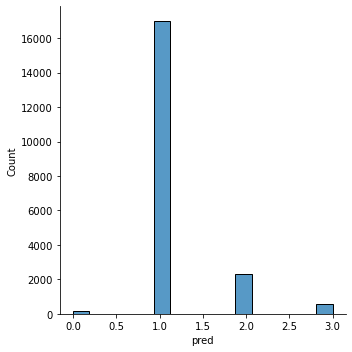

In [ ]:
sns.displot(train.pred)

In [ ]:
train.target

0        0
1        2
2        1
3        1
4        1
        ..
19995    1
19996    2
19997    0
19998    3
19999    1
Name: target, Length: 20000, dtype: int64

In [ ]:
(train.target==train.pred).sum()/len(train.target)

0.5366

----
# Merging